In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from joblib import dump, load
import os
from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

Reading Dataset

In [3]:
claims = pd.read_csv("Data\claims_table.csv")
policy = pd.read_csv("Data\policyholder_table.csv")

In [4]:
claims.head()

,Claim_ID,Policy_ID,Customer_ID,Accident_Date,FNOL_Date,Claim_Type,Estimated_Claim_Amount,Ultimate_Claim_Amount,Settlement_Date,Traffic_Condition,Weather_Condition
0,CLM_000001,POL_000001,CUST_77820,2020-03-02,2020-03-06,fire,8761.43,11509.99,2020-06-26,Low,Rainy
1,CLM_000002,POL_000002,CUST_88498,2023-01-09,2023-01-10,fire,12896.76,15470.00,2023-03-21,Low,Rainy
2,CLM_000003,POL_000003,CUST_60735,2022-12-25,2022-12-26,collision,12698.97,13500.00,2023-02-01,Low,Rainy
3,CLM_000004,POL_000003,CUST_60735,2021-11-24,2021-11-29,vandalism,2738.35,2714.92,2021-12-13,Moderate,Stormy
4,CLM_000005,POL_000003,CUST_60735,2022-10-01,2022-10-08,collision,16262.58,NaN,2022-12-06,Moderate,Rainy


In [5]:
policy.head()

,Policy_ID,Customer_ID,Date_of_Birth,Full_License_Issue_Date,Vehicle_Type,Vehicle_Year
0,POL_000001,CUST_77820,1983-04-20,2003-08-23,Sedan,2008
1,POL_000002,CUST_88498,1986-03-10,2007-07-26,Hatchback,2012
2,POL_000003,CUST_60735,1971-03-02,1989-07-05,Hatchback,2021
3,POL_000004,CUST_54707,1946-09-19,1968-01-12,Truck,2022
4,POL_000005,CUST_26658,1957-07-26,1977-08-07,SUV,2006


Data Preparation

Merging the dataset: join cliams dataset with policy dataset on Customer_ID to get the dataset in one place.

Data cleaning:
. Convert dates to datetime
. Handle missing values by filling the missing values(.fillna) or drop the missing values(.dropna)

Feature Engineering:

. Age = Accident_date - DOB

. Years_of_Experience = Accident_date - Full_liecense_issue_date

. FNOL_delay = FNOL_date - Accident_date

. Settlement_duration = Settlement_date - FNOL_date

Merging the Dataset

In [6]:
df_final = pd.merge(claims, policy, on=['Policy_ID', 'Customer_ID'], how='left')
df_final.head()

,Claim_ID,Policy_ID,Customer_ID,Accident_Date,FNOL_Date,Claim_Type,Estimated_Claim_Amount,Ultimate_Claim_Amount,Settlement_Date,Traffic_Condition,Weather_Condition,Date_of_Birth,Full_License_Issue_Date,Vehicle_Type,Vehicle_Year
0,CLM_000001,POL_000001,CUST_77820,2020-03-02,2020-03-06,fire,8761.43,11509.99,2020-06-26,Low,Rainy,1983-04-20,2003-08-23,Sedan,2008
1,CLM_000002,POL_000002,CUST_88498,2023-01-09,2023-01-10,fire,12896.76,15470.00,2023-03-21,Low,Rainy,1986-03-10,2007-07-26,Hatchback,2012
2,CLM_000003,POL_000003,CUST_60735,2022-12-25,2022-12-26,collision,12698.97,13500.00,2023-02-01,Low,Rainy,1971-03-02,1989-07-05,Hatchback,2021
3,CLM_000004,POL_000003,CUST_60735,2021-11-24,2021-11-29,vandalism,2738.35,2714.92,2021-12-13,Moderate,Stormy,1971-03-02,1989-07-05,Hatchback,2021
4,CLM_000005,POL_000003,CUST_60735,2022-10-01,2022-10-08,collision,16262.58,NaN,2022-12-06,Moderate,Rainy,1971-03-02,1989-07-05,Hatchback,2021


In [7]:
df_final.shape

(146987, 15)

In [8]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146987 entries, 0 to 146986
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Claim_ID                 146987 non-null  object 
 1   Policy_ID                146987 non-null  object 
 2   Customer_ID              146987 non-null  object 
 3   Accident_Date            146987 non-null  object 
 4   FNOL_Date                146987 non-null  object 
 5   Claim_Type               146987 non-null  object 
 6   Estimated_Claim_Amount   143989 non-null  float64
 7   Ultimate_Claim_Amount    144065 non-null  float64
 8   Settlement_Date          146987 non-null  object 
 9   Traffic_Condition        144027 non-null  object 
 10  Weather_Condition        143950 non-null  object 
 11  Date_of_Birth            146987 non-null  object 
 12  Full_License_Issue_Date  146987 non-null  object 
 13  Vehicle_Type             146987 non-null  object 
 14  Vehi

Checking for missing values

In [9]:
df_final.isnull().sum()

Claim_ID                      0
Policy_ID                     0
Customer_ID                   0
Accident_Date                 0
FNOL_Date                     0
Claim_Type                    0
Estimated_Claim_Amount     2998
Ultimate_Claim_Amount      2922
Settlement_Date               0
Traffic_Condition          2960
Weather_Condition          3037
Date_of_Birth                 0
Full_License_Issue_Date       0
Vehicle_Type                  0
Vehicle_Year                  0
dtype: int64

Filling or dropping missing values

In [10]:
missing_cols = df_final.columns[df_final.isnull().any()]

for col in missing_cols:
    print(f"{col}: {df_final[col].dtype}")

Estimated_Claim_Amount: float64
Ultimate_Claim_Amount: float64
Traffic_Condition: object
Weather_Condition: object


**Converting the date columns to proper datetime form**at

In [11]:
date_cols = ['Accident_Date', 'FNOL_Date', 'Settlement_Date', 'Date_of_Birth', 'Full_License_Issue_Date']

# convert to datetime
df_final[date_cols] = df_final[date_cols].apply(pd.to_datetime, errors='coerce')

# Trying to fix the missing values by inputting numerical columns with median
for col in ['Estimated_Claim_Amount', 'Ultimate_Claim_Amount']:
    df_final[col] = df_final[col].fillna(df_final[col].median())

# Trying to fix the missing values in the categorical columns by inputiing mode
for col in ['Traffic_Condition', 'Weather_Condition']:
    df_final[col] = df_final[col].fillna(df_final[col].mode()[0])

df_final.isnull().sum()

Claim_ID                   0
Policy_ID                  0
Customer_ID                0
Accident_Date              0
FNOL_Date                  0
Claim_Type                 0
Estimated_Claim_Amount     0
Ultimate_Claim_Amount      0
Settlement_Date            0
Traffic_Condition          0
Weather_Condition          0
Date_of_Birth              0
Full_License_Issue_Date    0
Vehicle_Type               0
Vehicle_Year               0
dtype: int64

**Checking the data information again after fixing all that need to be fixed in the dataset**

In [12]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146987 entries, 0 to 146986
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Claim_ID                 146987 non-null  object        
 1   Policy_ID                146987 non-null  object        
 2   Customer_ID              146987 non-null  object        
 3   Accident_Date            146987 non-null  datetime64[ns]
 4   FNOL_Date                146987 non-null  datetime64[ns]
 5   Claim_Type               146987 non-null  object        
 6   Estimated_Claim_Amount   146987 non-null  float64       
 7   Ultimate_Claim_Amount    146987 non-null  float64       
 8   Settlement_Date          146987 non-null  datetime64[ns]
 9   Traffic_Condition        146987 non-null  object        
 10  Weather_Condition        146987 non-null  object        
 11  Date_of_Birth            146987 non-null  datetime64[ns]
 12  Full_License_Iss

**checking for and dropping duplicates**

In [13]:
df_final.duplicated().sum()

np.int64(0)

From the output of the code above, it is observed that there are no duplicates present in the dataset.

**Feature engineering**

. Driver_age = Accident_date-Date_of_Birth

. Years_of_Experience = Accident_date - Full_liecense_Issue_date

. Fnol_Delay_date = FNOL_Date - Accident_date

. Settlement_duration = Settlement_date - FNOL_date

In [14]:
df_final["Driver_Age"] = (df_final["Accident_Date"] -df_final["Date_of_Birth"]).dt.days //365

df_final["Years_of_Experience"] = (df_final["Accident_Date"] -df_final["Full_License_Issue_Date"]).dt.days //365

df_final["Fnol_Delay_Date"] = (df_final["FNOL_Date"] - df_final["Accident_Date"]).dt.days

df_final["Settlement_Duration"] = (df_final["Settlement_Date"] -df_final["FNOL_Date"]).dt.days

In [15]:
df_final.head()

,Claim_ID,Policy_ID,Customer_ID,Accident_Date,FNOL_Date,Claim_Type,Estimated_Claim_Amount,Ultimate_Claim_Amount,Settlement_Date,Traffic_Condition,Weather_Condition,Date_of_Birth,Full_License_Issue_Date,Vehicle_Type,Vehicle_Year,Driver_Age,Years_of_Experience,Fnol_Delay_Date,Settlement_Duration
0,CLM_000001,POL_000001,CUST_77820,2020-03-02,2020-03-06,fire,8761.43,11509.99,2020-06-26,Low,Rainy,1983-04-20,2003-08-23,Sedan,2008,36,16,4,112
1,CLM_000002,POL_000002,CUST_88498,2023-01-09,2023-01-10,fire,12896.76,15470.00,2023-03-21,Low,Rainy,1986-03-10,2007-07-26,Hatchback,2012,36,15,1,70
2,CLM_000003,POL_000003,CUST_60735,2022-12-25,2022-12-26,collision,12698.97,13500.00,2023-02-01,Low,Rainy,1971-03-02,1989-07-05,Hatchback,2021,51,33,1,37
3,CLM_000004,POL_000003,CUST_60735,2021-11-24,2021-11-29,vandalism,2738.35,2714.92,2021-12-13,Moderate,Stormy,1971-03-02,1989-07-05,Hatchback,2021,50,32,5,14
4,CLM_000005,POL_000003,CUST_60735,2022-10-01,2022-10-08,collision,16262.58,10965.84,2022-12-06,Moderate,Rainy,1971-03-02,1989-07-05,Hatchback,2021,51,33,7,59


In [16]:
df_final.to_csv("Data/claims_policy_merged_cleaned.csv", index=False)

**Exploratory Data Analysis**

In [17]:
print("The Dataset Overview")
print("1. The highest claim amount and the lowest cliam amount")
print(f"The lowest claim amount is : {df_final['Ultimate_Claim_Amount'].min()}, and The highest cliam amount is : {df_final['Ultimate_Claim_Amount'].max()} ")
print("="*150)

print("2. The age range of the drivers, from the youngest to the oldest")
print(f"The youngest driver's age is : {df_final['Driver_Age'].min()} and the oldest driver's age is : {df_final['Driver_Age'].max()}")
print("="*150)

print("3. The claim type with the highest claim amount and the claim type with the lowest claim amount")
claim_type = df_final.groupby("Claim_Type").agg({
    "Estimated_Claim_Amount": "sum",
    "Ultimate_Claim_Amount": "sum"
}).reset_index()
print(f"The claim type with the lowest cost is {claim_type.loc[claim_type['Estimated_Claim_Amount'].idxmin(), 'Claim_Type']}, with total claim amount of {claim_type['Estimated_Claim_Amount'].min():,}")
print(f"The cliam type with the highest cost is {claim_type.loc[claim_type['Estimated_Claim_Amount'].idxmax(), 'Claim_Type']}, with total claim amount of {claim_type['Estimated_Claim_Amount'].max():,}")
print("="*150)

print("4. The traffic condition that appears most in the claim")
print(f"The traffic condition that appears most in the claim is : {df_final['Traffic_Condition'].value_counts()}")
print("="*150)

print("5. The weather condition that appear most in the claim")
print(f"The weather condition that appeared in the claim are as follows : {df_final['Weather_Condition'].value_counts()}")
print("="*150)

print("5. Weather condition and their impact on claim amount.")
weather_claim_impact = df_final.groupby("Weather_Condition").agg({
    'Estimated_Claim_Amount': "sum",
    "Ultimate_Claim_Amount" : "sum"
}).reset_index()
weather_claim_impact = weather_claim_impact.sort_values('Ultimate_Claim_Amount', ascending=False)
weather_claim_impact.head()



The Dataset Overview
1. The highest claim amount and the lowest cliam amount
The lowest claim amount is : 450.0, and The highest cliam amount is : 234000.0 
2. The age range of the drivers, from the youngest to the oldest
The youngest driver's age is : 18 and the oldest driver's age is : 84
3. The claim type with the highest claim amount and the claim type with the lowest claim amount
The claim type with the lowest cost is glass, with total claim amount of 22,944,939.03
The cliam type with the highest cost is collision, with total claim amount of 752,624,572.44
4. The traffic condition that appears most in the claim
The traffic condition that appears most in the claim is : Traffic_Condition
Moderate    75034
High        36104
Low         28647
Severe       7202
Name: count, dtype: int64
5. The weather condition that appear most in the claim
The weather condition that appeared in the claim are as follows : Weather_Condition
Rainy     60616
Foggy     28884
Snowy     28771
Stormy    14433

,Weather_Condition,Estimated_Claim_Amount,Ultimate_Claim_Amount
2,Rainy,1.080873e+09,1.059460e+09
1,Foggy,5.133216e+08,5.030657e+08
3,Snowy,5.053553e+08,4.972387e+08
4,Stormy,2.553265e+08,2.522643e+08
0,Clear,2.527053e+08,2.484780e+08


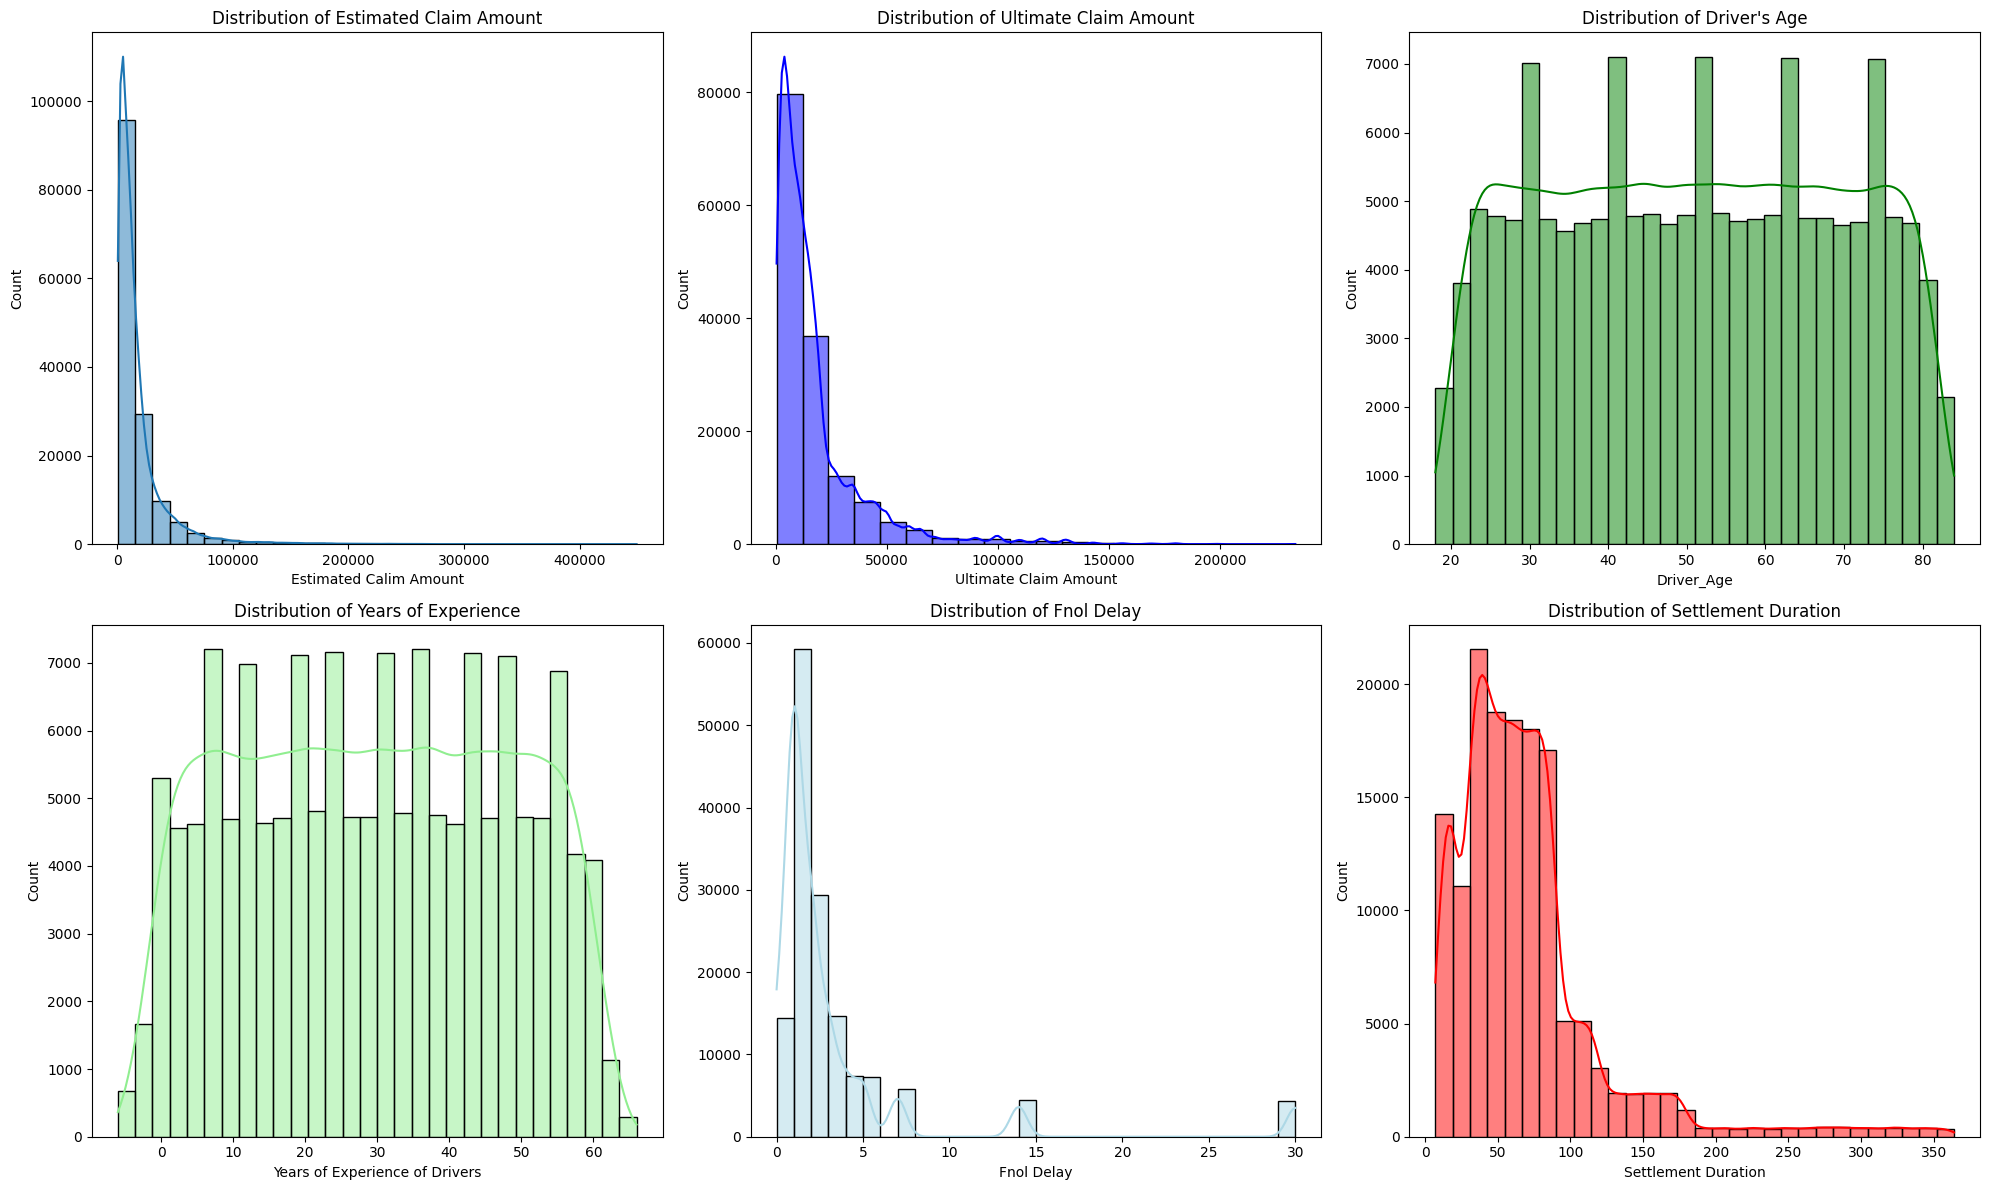

In [18]:
plt.figure(figsize=(20,12))


plt.subplot(2,3,1)
# Histogram for Estimated_Claim_Amount
sns.histplot(data = df_final, x="Estimated_Claim_Amount", bins=30, kde=True)
plt.title("Distribution of Estimated Claim Amount")
plt.xlabel("Estimated Calim Amount")


#Histogram plot for Ultimate Claim Amount
plt.subplot(2,3,2)
sns.histplot(data=df_final,x='Ultimate_Claim_Amount', bins=20, kde=True, color='blue')
plt.title("Distribution of Ultimate Claim Amount")
plt.xlabel("Ultimate Claim Amount")

# Histogram plot for Driver's Age
plt.subplot(2,3,3)
sns.histplot(data=df_final, x="Driver_Age",bins=30, kde=True, color="green")
plt.title("Distribution of Driver's Age")

# Histogram plot for Year of Experience
plt.subplot(2,3,4)
sns.histplot(data=df_final, x="Years_of_Experience", bins=30, kde=True, color="lightgreen")
plt.title("Distribution of Years of Experience")
plt.xlabel("Years of Experience of Drivers")


# Histogram plot for Fnol Delay
plt.subplot(2,3,5)
sns.histplot(data=df_final, x="Fnol_Delay_Date", bins=30, kde=True, color="lightblue")
plt.title("Distribution of Fnol Delay")
plt.xlabel("Fnol Delay")

# Histogram plot for settlement Duration
plt.subplot(2,3,6)
sns.histplot(data=df_final, x="Settlement_Duration", bins=30, kde=True, color="red")
plt.title("Distribution of Settlement Duration")
plt.xlabel("Settlement Duration")
plt.tight_layout()
plt.show()

**Categorical Column Analysis**

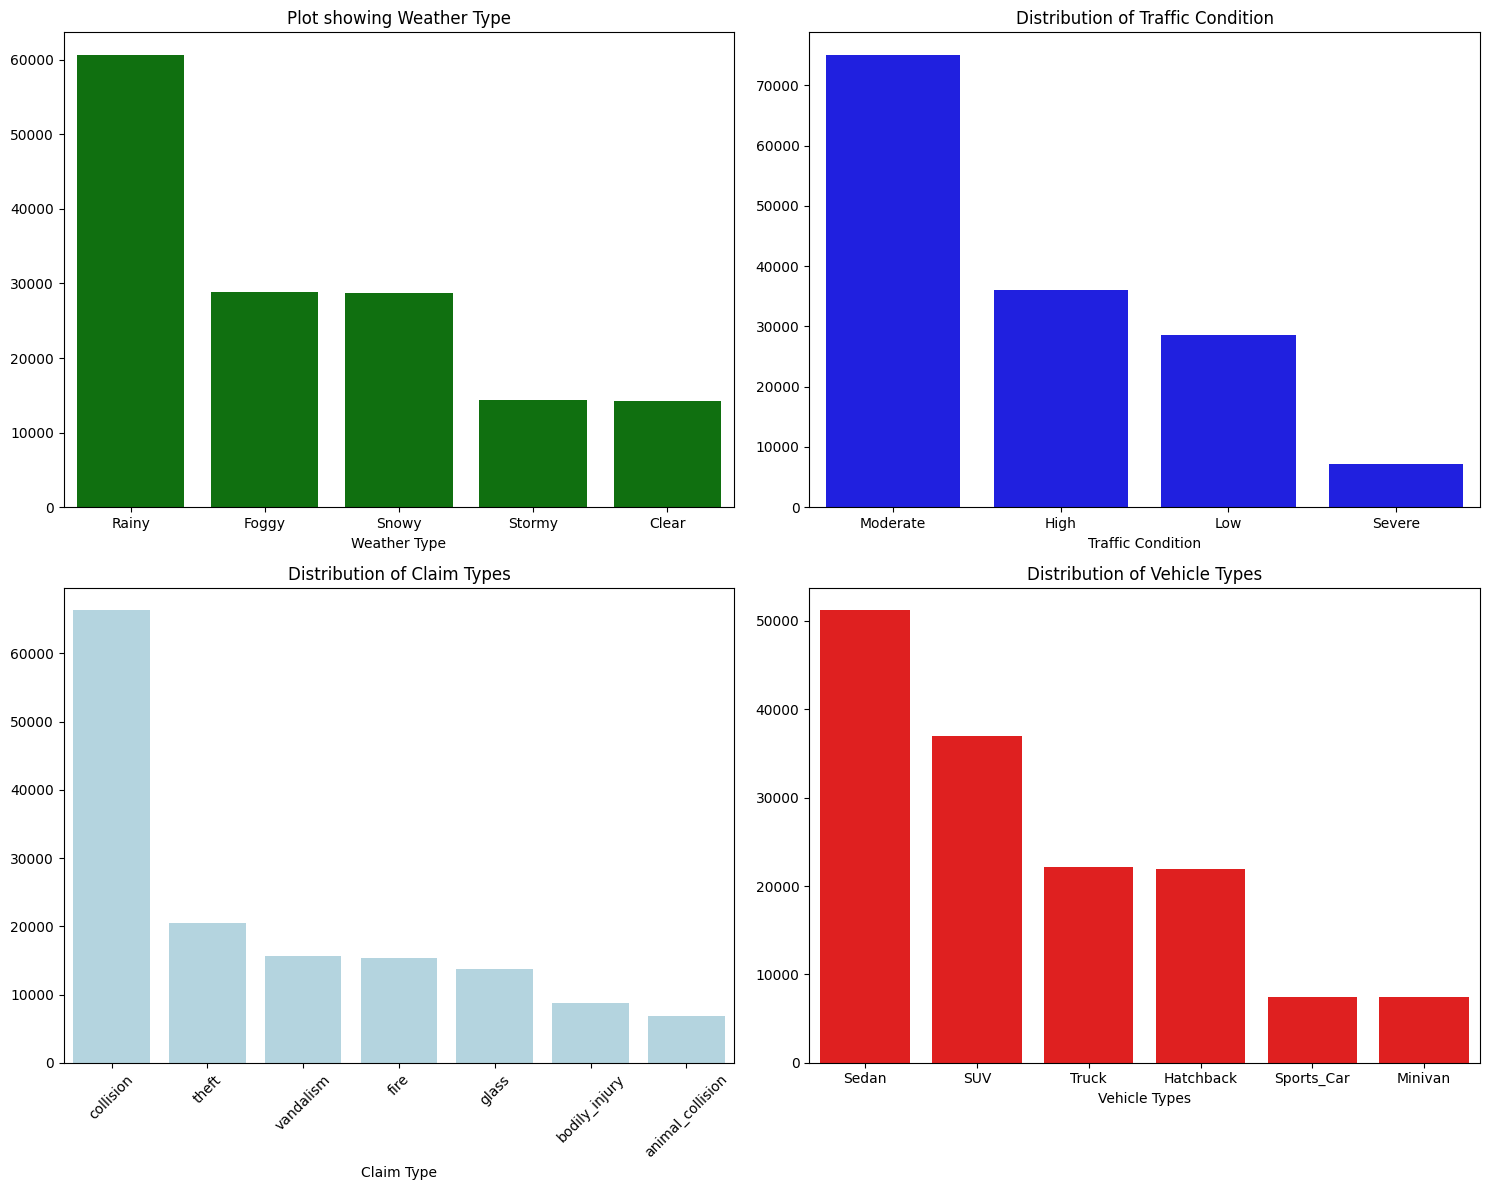

In [19]:
plt.figure(figsize=(15,12))

# Barplot for weather type
plt.subplot(2,2,1)
weather = df_final['Weather_Condition'].value_counts()
sns.barplot(x=weather.index, y=weather.values, color='green')
plt.title("Plot showing Weather Type")
plt.xlabel("Weather Type")

# Barplot for Traffic Condition
plt.subplot(2,2,2)
traffic = df_final["Traffic_Condition"].value_counts()
sns.barplot(x=traffic.index, y=traffic.values, color='blue')
plt.title("Distribution of Traffic Condition")
plt.xlabel("Traffic Condition")

# Barplot for Claim Type
plt.subplot(2,2,3)
claim = df_final["Claim_Type"].value_counts()
sns.barplot(x=claim.index, y=claim.values, color='lightblue')
plt.title("Distribution of Claim Types")
plt.xlabel("Claim Type")
plt.xticks(rotation=45)

# Barplot for Vehicle Type
plt.subplot(2,2,4)
vehicle = df_final["Vehicle_Type"].value_counts()
sns.barplot(x=vehicle.index, y=vehicle.values, color='red')
plt.title("Distribution of Vehicle Types")
plt.xlabel("Vehicle Types")

plt.tight_layout()
plt.show()


**Seasonal Claims Trend Across Years**

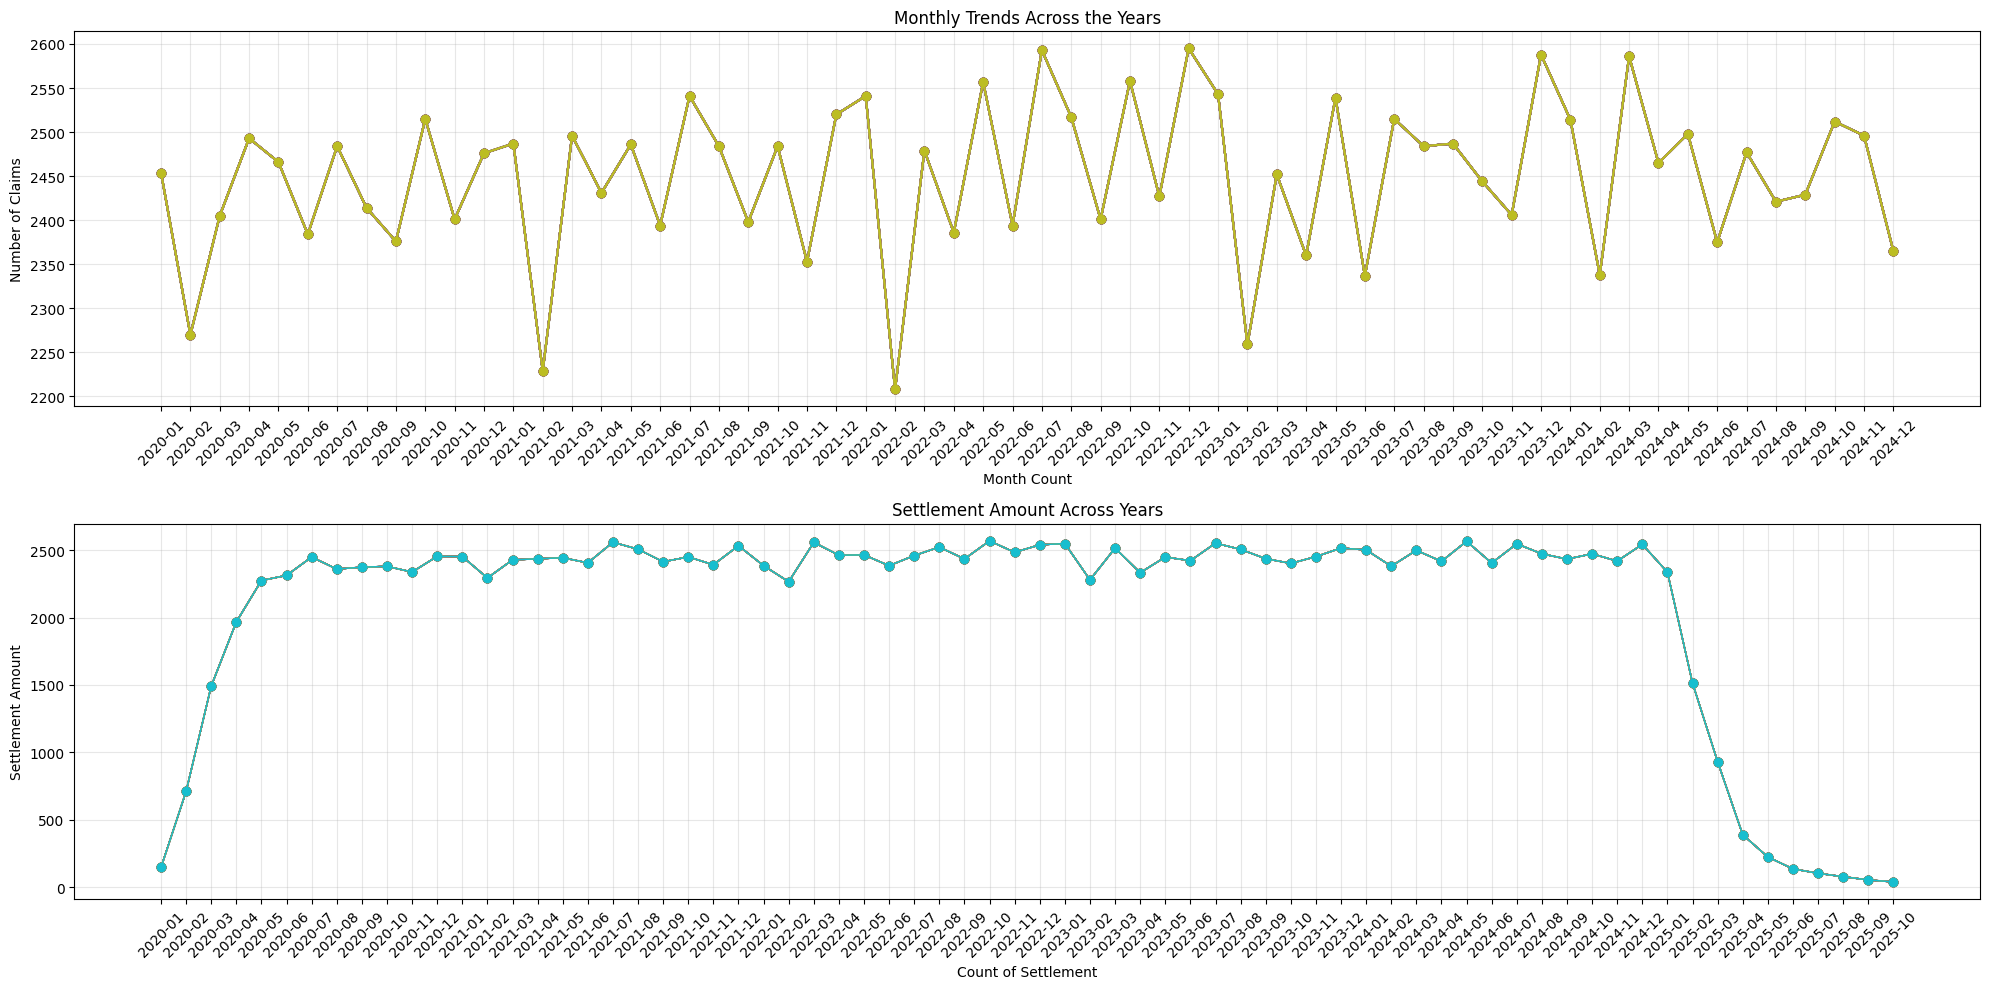

In [20]:
df_final["Accident_YearMonth"] = df_final["Accident_Date"].dt.strftime("%Y-%m")
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
monthly_claims = df_final.groupby("Accident_YearMonth").count()
plt.plot(monthly_claims.index.astype(str), monthly_claims.values, marker='o', linewidth=1.5)
plt.title("Monthly Trends Across the Years")
plt.xlabel("Month Count")
plt.ylabel("Number of Claims")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)


plt.subplot(2,1,2)
df_final["Settlement_YearMonth"] = df_final["Settlement_Date"].dt.strftime("%Y-%m")
settlement_amount = df_final.groupby("Settlement_YearMonth").count()
plt.plot(settlement_amount.index.astype(str), settlement_amount.values, marker='o', linewidth=1)
plt.title("Settlement Amount Across Years")
plt.ylabel("Settlement Amount")
plt.xlabel("Count of Settlement")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Bi Variate Exploratory Data Analysis**

.  Claim Type vs Ultimate Calim

.  Weather Condition vs Ultimate Claim

.  Vehicle Type vs Ultimate Claim

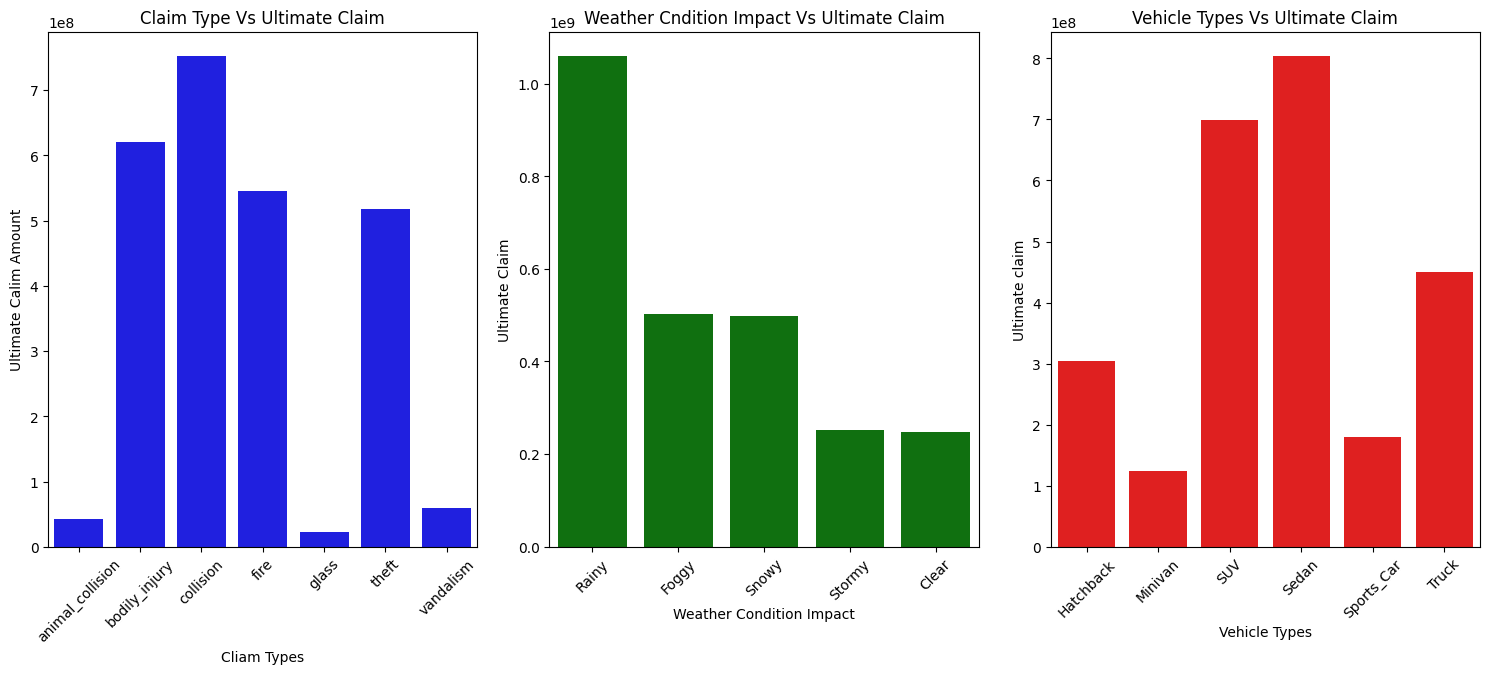

In [21]:
plt.figure(figsize=(15,7))

claim_type_per_amount = df_final.groupby("Claim_Type").agg({
    "Estimated_Claim_Amount": "sum",
    "Ultimate_Claim_Amount": "sum"
}).reset_index()

weather_condition_impact = df_final.groupby("Weather_Condition").agg({
    "Estimated_Claim_Amount": "sum",
    "Ultimate_Claim_Amount": "sum"
}).reset_index()

vehicle_type_per_amount = df_final.groupby("Vehicle_Type").agg({
    "Estimated_Claim_Amount": "sum",
    "Ultimate_Claim_Amount": "sum"
}).reset_index()




plt.subplot(1,3,1)
sns.barplot(data=claim_type_per_amount, x="Claim_Type", y="Ultimate_Claim_Amount", color="blue")
plt.title("Claim Type Vs Ultimate Claim")
plt.ylabel("Ultimate Calim Amount")
plt.xlabel("Cliam Types")
plt.xticks(rotation=45)


plt.subplot(1,3,2)
sns.barplot(data=weather_claim_impact, x="Weather_Condition", y="Ultimate_Claim_Amount", color="green")
plt.title("Weather Cndition Impact Vs Ultimate Claim")
plt.ylabel("Ultimate Claim")
plt.xlabel("Weather Condition Impact")
plt.xticks(rotation=45)


plt.subplot(1,3,3)
sns.barplot(data=vehicle_type_per_amount, x="Vehicle_Type", y="Ultimate_Claim_Amount", color="red")
plt.title("Vehicle Types Vs Ultimate Claim")
plt.ylabel("Ultimate claim")
plt.xlabel("Vehicle Types")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**Detecting Outliers Using Box Plot**

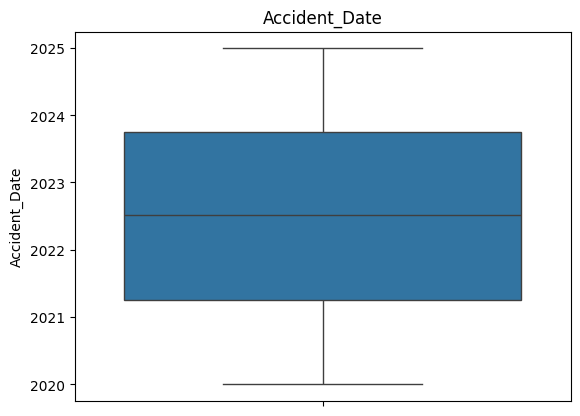

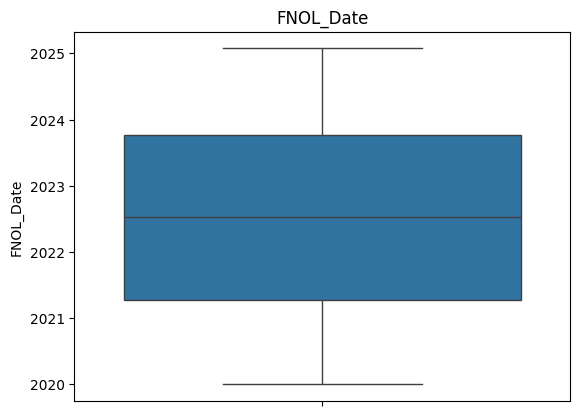

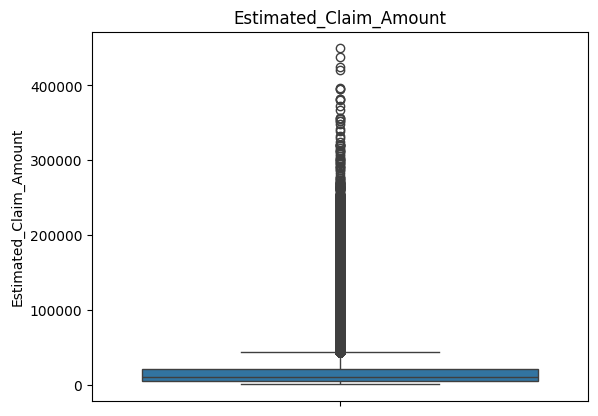

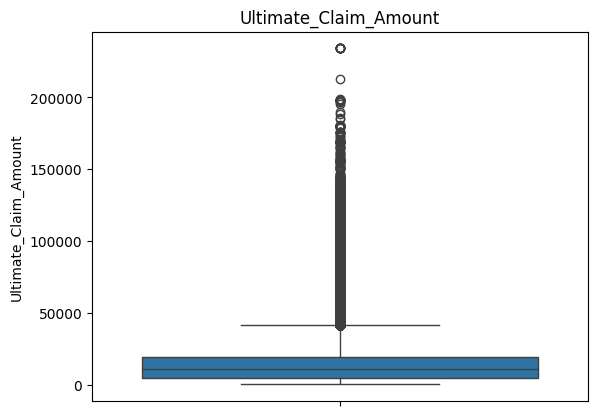

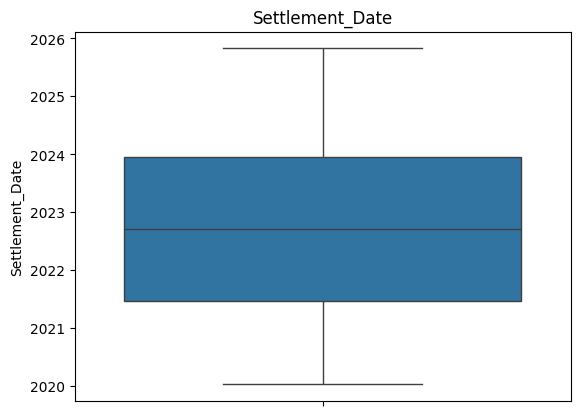

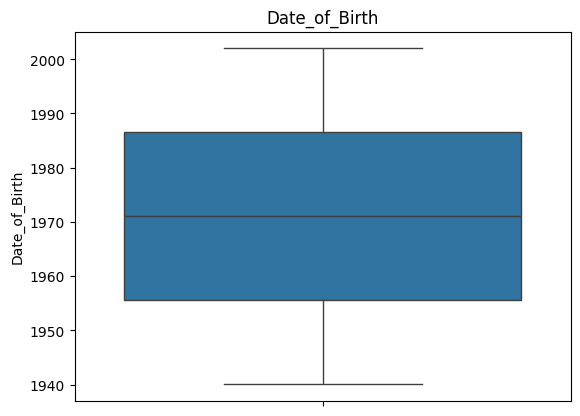

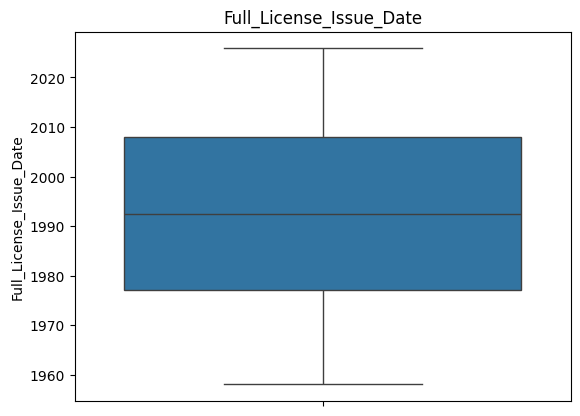

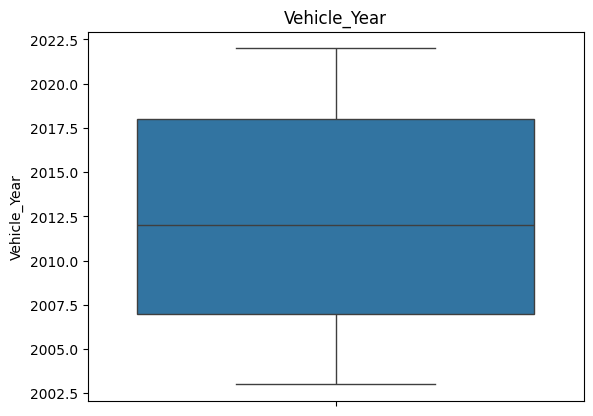

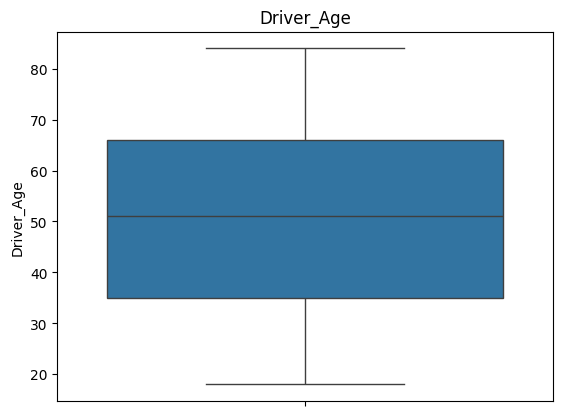

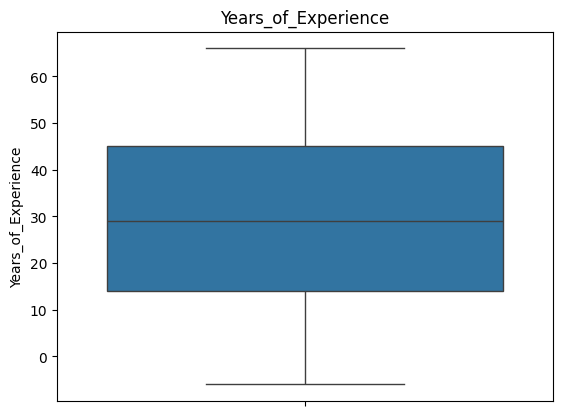

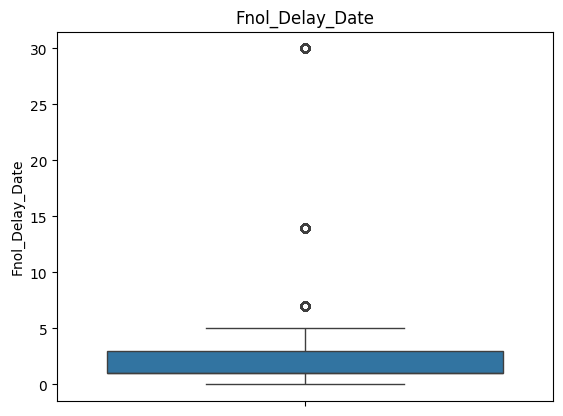

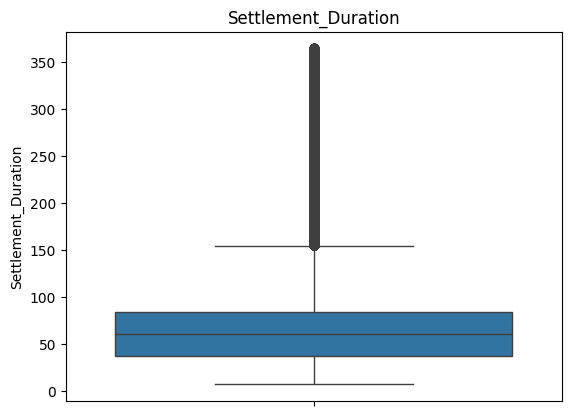

In [22]:
for col in df_final.columns:
    if df_final[col].dtype!=object:
        sns.boxplot(df_final[col])
        plt.title(f"{col}")
        plt.show()

**Getting the values of outliers**

In [23]:
def get_iqr(df_final,col):
    Q1 = df_final[col].quantile(0.25)
    Q3 = df_final[col].quantile(0.75)
    IQR = Q3 -Q1
    
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    mask = (df_final[col] < lower) | (df_final[col] > upper)
    return mask

iqr_outliers = pd.DataFrame()

for col in df_final:
    if df_final[col].dtype!=object:
        iqr_outliers[col] = get_iqr(df_final, col)
    

print(iqr_outliers.sum())

Accident_Date                  0
FNOL_Date                      0
Estimated_Claim_Amount     13022
Ultimate_Claim_Amount      14735
Settlement_Date                0
Date_of_Birth                  0
Full_License_Issue_Date        0
Vehicle_Year                   0
Driver_Age                     0
Years_of_Experience            0
Fnol_Delay_Date            14633
Settlement_Duration         9900
dtype: int64


**Fixing outliers**

we can fix outliers either by removing them or by capping

In [24]:
def winsorize(df,col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 -Q1
    
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    df[col] = df[col].clip(lower,upper)
    return df

In [25]:
outlier_columns = ["Estimated_Claim_Amount","Ultimate_Claim_Amount", "Fnol_Delay_Date", "Settlement_Duration"]

# Applying winsorize to all the outlier columns
for col in outlier_columns:
    df_final = winsorize(df_final, col)

print("Outliers corrected successfully")

Outliers corrected successfully


**Validating the operation that we have just done by rechecking if we still have the outliers**

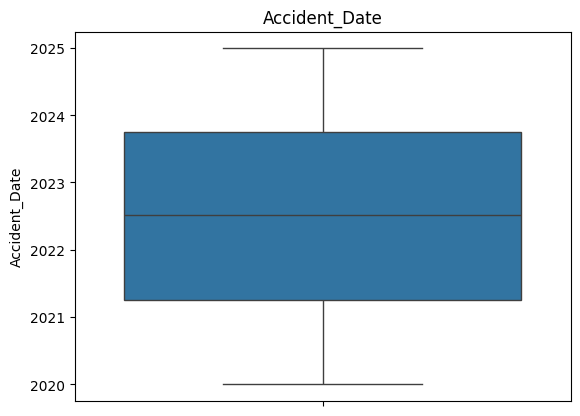

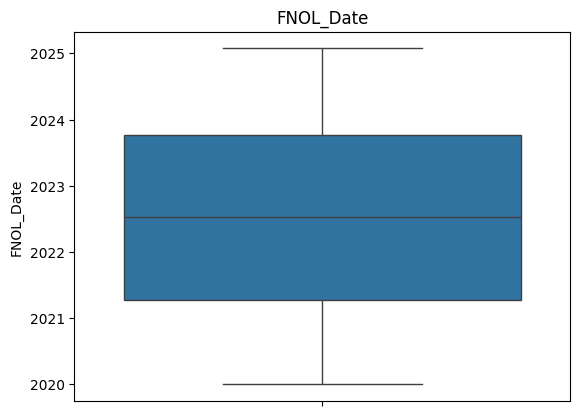

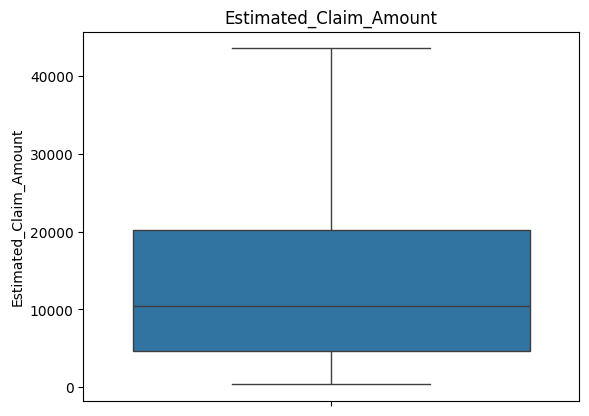

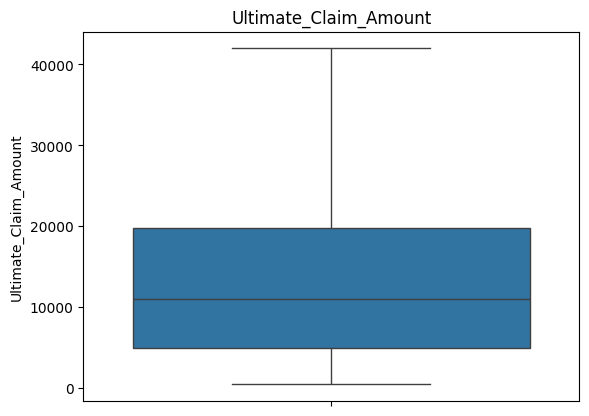

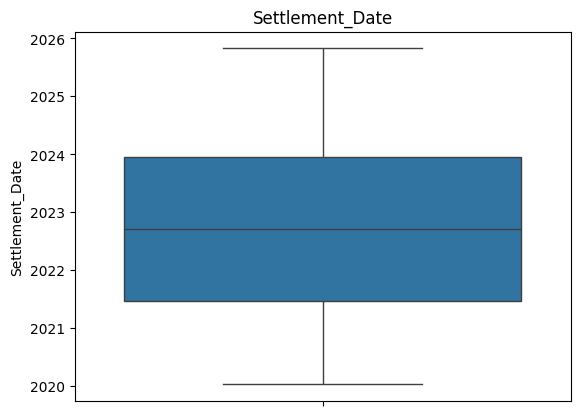

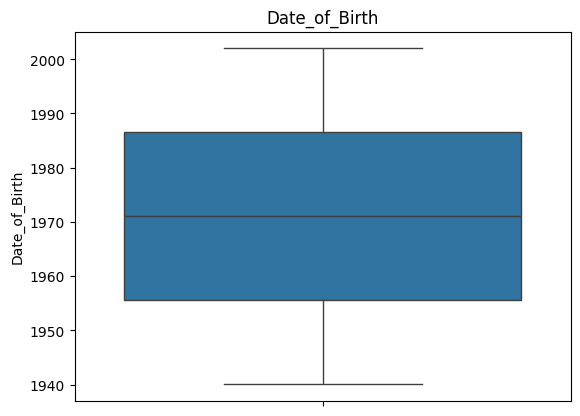

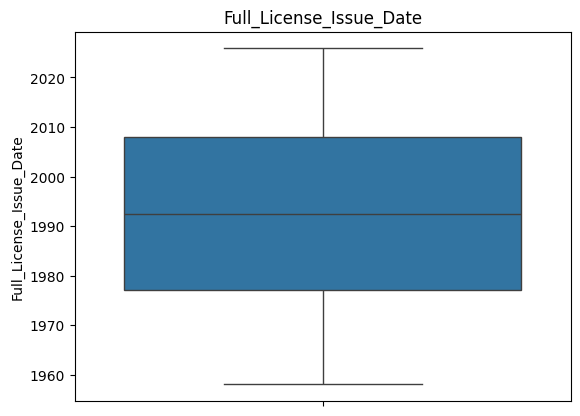

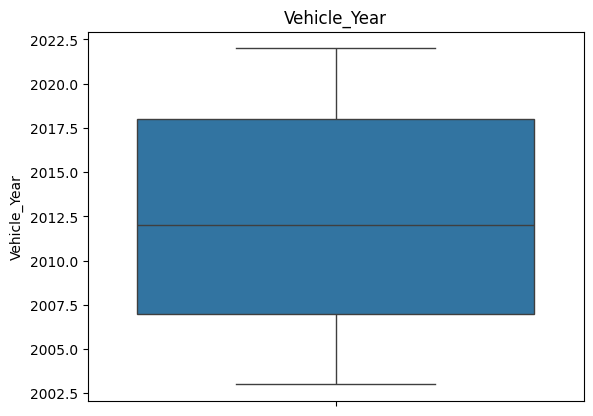

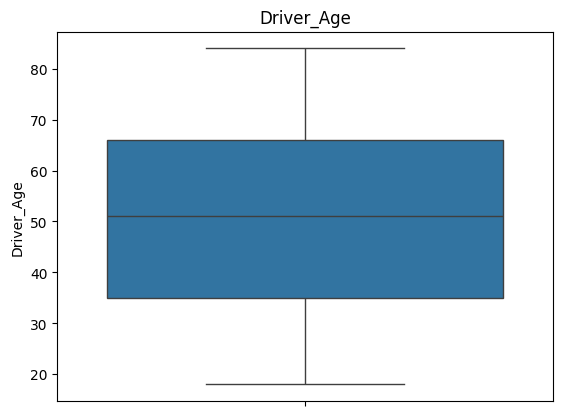

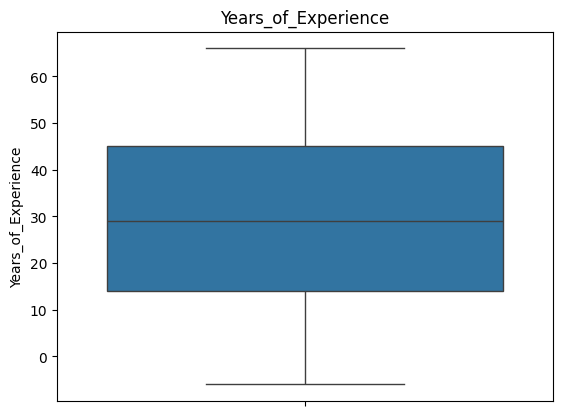

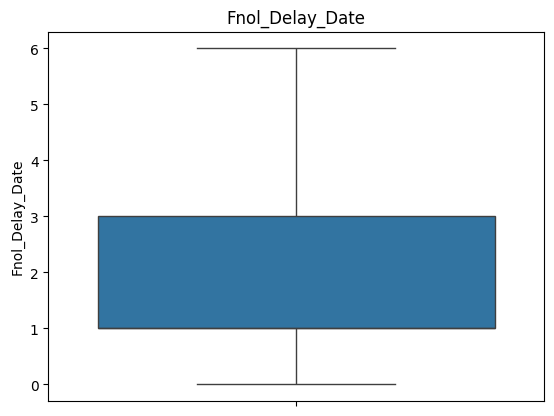

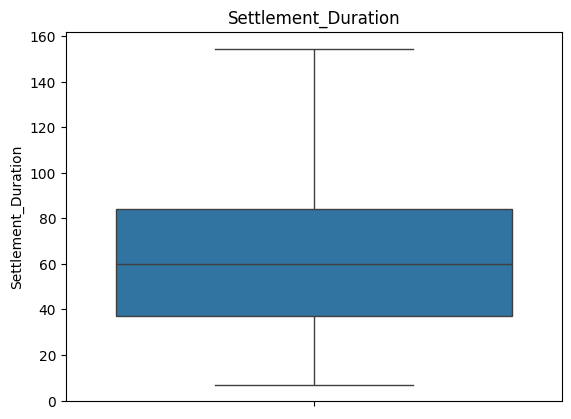

In [26]:
for col in df_final.columns:
    if df_final[col].dtype!=object:
        sns.boxplot(df_final[col])
        plt.title(f"{col}")
        plt.show()

In [27]:
def get_iqr(df_final,col):
    Q1 = df_final[col].quantile(0.25)
    Q3 = df_final[col].quantile(0.75)
    IQR = Q3 -Q1
    
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    mask = (df_final[col] < lower) | (df_final[col] > upper)
    return mask

iqr_outliers = pd.DataFrame()

for col in df_final:
    if df_final[col].dtype!=object:
        iqr_outliers[col] = get_iqr(df_final, col)
    

print(iqr_outliers.sum())

Accident_Date              0
FNOL_Date                  0
Estimated_Claim_Amount     0
Ultimate_Claim_Amount      0
Settlement_Date            0
Date_of_Birth              0
Full_License_Issue_Date    0
Vehicle_Year               0
Driver_Age                 0
Years_of_Experience        0
Fnol_Delay_Date            0
Settlement_Duration        0
dtype: int64


In [28]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146987 entries, 0 to 146986
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Claim_ID                 146987 non-null  object        
 1   Policy_ID                146987 non-null  object        
 2   Customer_ID              146987 non-null  object        
 3   Accident_Date            146987 non-null  datetime64[ns]
 4   FNOL_Date                146987 non-null  datetime64[ns]
 5   Claim_Type               146987 non-null  object        
 6   Estimated_Claim_Amount   146987 non-null  float64       
 7   Ultimate_Claim_Amount    146987 non-null  float64       
 8   Settlement_Date          146987 non-null  datetime64[ns]
 9   Traffic_Condition        146987 non-null  object        
 10  Weather_Condition        146987 non-null  object        
 11  Date_of_Birth            146987 non-null  datetime64[ns]
 12  Full_License_Iss

**Addressing skewness in the target variable which is the Ultimate cliam Amount**

In [29]:
df_final["Ultimate_Claim_Amount"] = np.log1p(df_final["Ultimate_Claim_Amount"])

**Feature Selection**

In [30]:
df_final.head()

,Claim_ID,Policy_ID,Customer_ID,Accident_Date,FNOL_Date,Claim_Type,Estimated_Claim_Amount,Ultimate_Claim_Amount,Settlement_Date,Traffic_Condition,...,Date_of_Birth,Full_License_Issue_Date,Vehicle_Type,Vehicle_Year,Driver_Age,Years_of_Experience,Fnol_Delay_Date,Settlement_Duration,Accident_YearMonth,Settlement_YearMonth
0,CLM_000001,POL_000001,CUST_77820,2020-03-02,2020-03-06,fire,8761.43,9.351058,2020-06-26,Low,...,1983-04-20,2003-08-23,Sedan,2008,36,16,4,112.0,2020-03,2020-06
1,CLM_000002,POL_000002,CUST_88498,2023-01-09,2023-01-10,fire,12896.76,9.646723,2023-03-21,Low,...,1986-03-10,2007-07-26,Hatchback,2012,36,15,1,70.0,2023-01,2023-03
2,CLM_000003,POL_000003,CUST_60735,2022-12-25,2022-12-26,collision,12698.97,9.510519,2023-02-01,Low,...,1971-03-02,1989-07-05,Hatchback,2021,51,33,1,37.0,2022-12,2023-02
3,CLM_000004,POL_000003,CUST_60735,2021-11-24,2021-11-29,vandalism,2738.35,7.906886,2021-12-13,Moderate,...,1971-03-02,1989-07-05,Hatchback,2021,50,32,5,14.0,2021-11,2021-12
4,CLM_000005,POL_000003,CUST_60735,2022-10-01,2022-10-08,collision,16262.58,9.302631,2022-12-06,Moderate,...,1971-03-02,1989-07-05,Hatchback,2021,51,33,6,59.0,2022-10,2022-12


**Plotting the Heatmap for the Numerical columns**

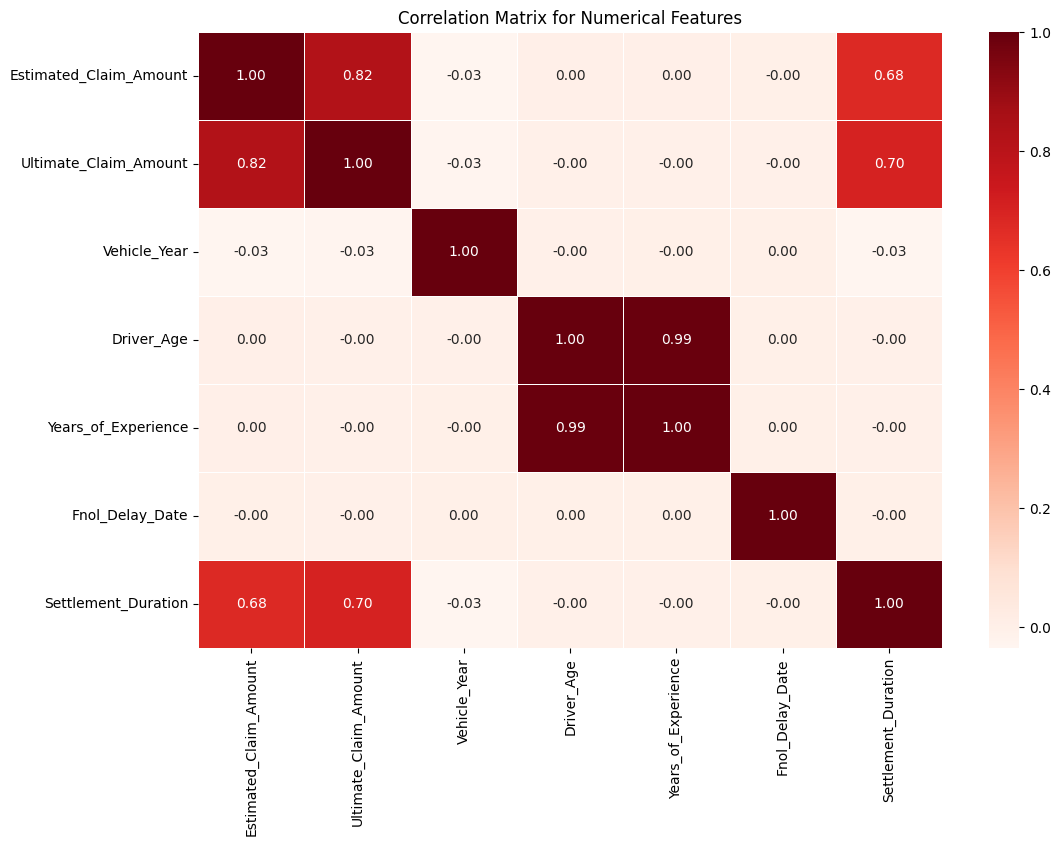

In [31]:
new_df = df_final.select_dtypes(exclude=['object', 'datetime'])
plt.figure(figsize=(12,8))
sns.heatmap(new_df.corr(), annot=True, fmt='.2f', cmap='Reds', linewidths=0.5)
plt.title("Correlation Matrix for Numerical Features")
plt.show()

In [32]:
features = ['Claim_Type','Estimated_Claim_Amount','Traffic_Condition', 'Weather_Condition', 'Vehicle_Type', 'Vehicle_Year','Driver_Age','Years_of_Experience']
target = ['Ultimate_Claim_Amount']

In [33]:
df_final = df_final[features + target]

**Encoding the categorical columns in our dataset**

In [34]:
categorical_features = ['Traffic_Condition', 'Weather_Condition', 'Vehicle_Type', 'Claim_Type']
df_final = pd.get_dummies(df_final, columns=categorical_features, drop_first=False, dtype=int)

In [35]:
x = df_final.drop("Ultimate_Claim_Amount", axis=1)
y = df_final['Ultimate_Claim_Amount']

In [36]:
x.head()

,Estimated_Claim_Amount,Vehicle_Year,Driver_Age,Years_of_Experience,Traffic_Condition_High,Traffic_Condition_Low,Traffic_Condition_Moderate,Traffic_Condition_Severe,Weather_Condition_Clear,Weather_Condition_Foggy,...,Vehicle_Type_Sedan,Vehicle_Type_Sports_Car,Vehicle_Type_Truck,Claim_Type_animal_collision,Claim_Type_bodily_injury,Claim_Type_collision,Claim_Type_fire,Claim_Type_glass,Claim_Type_theft,Claim_Type_vandalism
0,8761.43,2008,36,16,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,12896.76,2012,36,15,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,12698.97,2021,51,33,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,2738.35,2021,50,32,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,16262.58,2021,51,33,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [37]:
y.head()

0    9.351058
1    9.646723
2    9.510519
3    7.906886
4    9.302631
Name: Ultimate_Claim_Amount, dtype: float64

In [38]:
x_train, x_test, y_train, y_test =train_test_split(x,y,test_size=0.2, random_state=42)

**Model Development**


. Linear Regression

. Random Forest

. Gradient Boosting

In [39]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [40]:
Random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [41]:
Random_forest_model.fit(x_train,y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [42]:
rf_pred = Random_forest_model.predict(x_test)

In [43]:
rf_pred_actual = np.expm1(rf_pred)

In [44]:
rf_pred_actual[:10]

array([37236.71850632, 19401.26173606, 11970.62286929, 12257.91191744,
        9429.3819415 , 11996.91256145,  5607.94919316, 27557.76638569,
       34571.63229518, 19111.62825882])

In [45]:
y_test = np.expm1(y_test)
y_test[:10]

2136      41983.1675
26563     12050.8500
48955     14850.0000
113544    15939.2200
85113      9227.8400
38001     20180.8000
127421     6000.0000
103538    22116.4900
96573     41983.1675
131673    18253.4000
Name: Ultimate_Claim_Amount, dtype: float64

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluation_metrics(x_test, y_test, model):
    model_pred_log = model.predict(x_test)
    model_pred = np.expm1(model_pred_log)

    mae = mean_absolute_error(y_test, model_pred)
    mse = mean_squared_error(y_test, model_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, model_pred)

    print("MAE =", mae)
    print("MSE =", mse)
    print("RMSE =", rmse)
    print("R2 Score=", r2)

evaluation_metrics(x_test,y_test,Random_forest_model)


MAE = 2530.108678806274
MSE = 18115042.207395893
RMSE = 4256.176947378468
R2 Score= 0.8886688978362206


**Building Model 2 using LInear Regression**

In [47]:
from sklearn.linear_model import LinearRegression

In [48]:
lr = LinearRegression()

In [49]:
lr.fit(x_train,y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [50]:
y_pred_lr = lr.predict(x_test)
y_pred_lr

array([10.3823361 ,  9.60170161,  9.11914472, ...,  9.91692941,
        7.98642789,  9.05793827], shape=(29398,))

In [51]:
y_pred_lr_actual = np.expm1(y_pred_lr)
y_pred_lr_actual

array([32283.29287182, 14788.92690968,  9127.39098893, ...,
       20269.6521686 ,  2939.77340713,  8585.42947016], shape=(29398,))

In [52]:
mae = mean_absolute_error(y_test, y_pred_lr_actual)
mse = mean_squared_error(y_test, y_pred_lr_actual)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_lr_actual)

print("MAE =", mae)
print("MSE =", mse)
print("RMSE =", rmse)
print("R2 Score=", r2)

MAE = 3925.3560129398015
MSE = 37300753.792126216
RMSE = 6107.434305183005
R2 Score= 0.7707576949767341


**Building Model 3 Using Gradient Boosting Technique**

In [53]:
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

In [54]:
gb_model.fit(x_train, y_train)

,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.1
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",100
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft 

In [55]:
y_pred_gb = gb_model.predict(x_test)
y_pred_gb

array([10.49477629,  9.83551809,  9.41160211, ..., 10.17077178,
        7.8260676 ,  8.98331511], shape=(29398,))

In [56]:
y_pred_gb_actual = np.expm1(y_pred_gb)
y_pred_gb_actual

array([36125.29580777, 18684.780031  , 12228.44820591, ...,
       26127.23431379,  2504.05907923,  7968.00653376], shape=(29398,))

In [57]:
mae = mean_absolute_error(y_test, y_pred_gb_actual)
mse = mean_squared_error(y_test, y_pred_gb_actual)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_gb_actual)

print("MAE =", mae)
print("MSE =", mse)
print("RMSE =", rmse)
print("R2 Score=", r2)

MAE = 2579.1518718924003
MSE = 18254038.216629885
RMSE = 4272.474484023267
R2 Score= 0.8878146586505085


**Hyperparameter Tuning for the Random Forest Model**

In [58]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'] 
}

In [59]:
from sklearn.model_selection import RandomizedSearchCV
rf_hyper = RandomizedSearchCV(
    estimator = RandomForestRegressor(random_state=42),
    param_distributions = param_grid,
    n_iter = 10,
    cv = 5,
    verbose = 1,
    n_jobs = -1
)

In [60]:
rf_hyper.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestR...ndom_state=42)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'max_depth': [10, 20, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",10
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here...

In [61]:
rf_best_model = rf_hyper.best_estimator_

In [62]:
evaluation_metrics(x_test=x_test, y_test=y_test, model=rf_best_model)

MAE = 2657.5434456545545
MSE = 18291152.982759602
RMSE = 4276.815752725338
R2 Score= 0.8875865593851319


**Model Tracking Using MLFlow**

In [63]:
import mlflow
from pathlib import Path


In [64]:
mlruns_path = Path("mlruns").absolute()
mlflow.set_tracking_uri(f"file:///{mlruns_path}")
mlflow.set_experiment("FNOL_ULTIMATE_CLAIM_EXPERIMENT")

<Experiment: artifact_location='file:///c:\\Users\\HP\\Desktop\\PROJECTS\\FNOL\\mlruns/215703976502679076', creation_time=1766979521601, experiment_id='215703976502679076', last_update_time=1766979521601, lifecycle_stage='active', name='FNOL_ULTIMATE_CLAIM_EXPERIMENT', tags={}>

In [65]:
mlflow.get_tracking_uri()

'file:///c:\\Users\\HP\\Desktop\\PROJECTS\\mlruns'

In [66]:
models = {
    'rf_model':Random_forest_model,
    'lr_model':lr,
    'gradient_b_model':gb_model,
    'best_model':rf_best_model
}

In [67]:
for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name):

        if hasattr(model, "get_params"):
            mlflow.log_params(model.get_params())

        model_iteration = model.predict(x_test)
        model_iteration_actual = np.expm1(model_iteration)

        mae = mean_absolute_error(y_test, model_iteration_actual)
        mse = mean_squared_error(y_test, model_iteration_actual)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, model_iteration_actual)


        mlflow.log_metrics({
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R2": r2
        })

        mlflow.sklearn.log_model(model, model_name)

print("All models logged successfully")


2026/01/18 06:22:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/18 06:22:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/18 06:23:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/18 06:23:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


All models logged successfully


In [68]:
mlflow.get_tracking_uri()

'file:///c:\\Users\\HP\\Desktop\\PROJECTS\\mlruns'

**SHAP AND LIME**

100%|██████████| 5/5 [00:48<00:00,  9.63s/it]


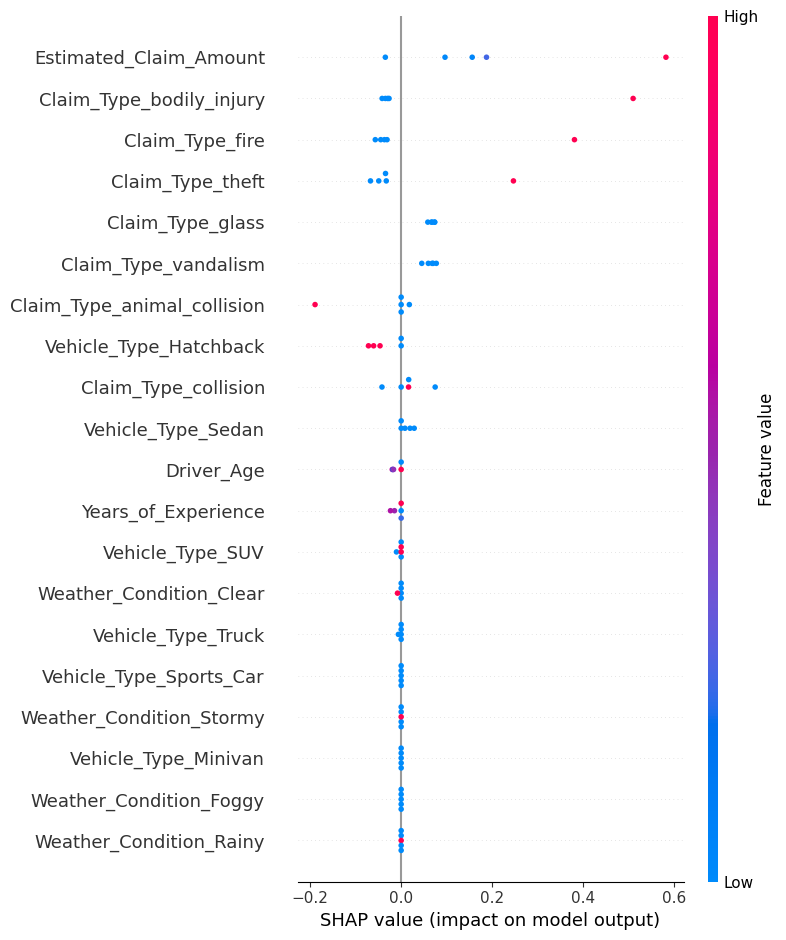

In [69]:
import shap
import pandas as pd

# create a wrapper function that handles the pipeline
def pipeline_predict(x):
    if isinstance(x, np.ndarray):
        x = pd.DataFrame(x, columns=x_train.columns)
        return rf_best_model.predict(x)
    
# use smaller background data
x_background = shap.sample(x_train, 100)
x_test_sample_small = x_test.iloc[:5]

# Use kernelExplainer with the wrapper
explainer = shap.KernelExplainer(pipeline_predict, x_background)
shap_values = explainer.shap_values(x_test_sample_small)

# Plot results
shap.summary_plot(shap_values, x_test_sample_small)

**Feature Importance**

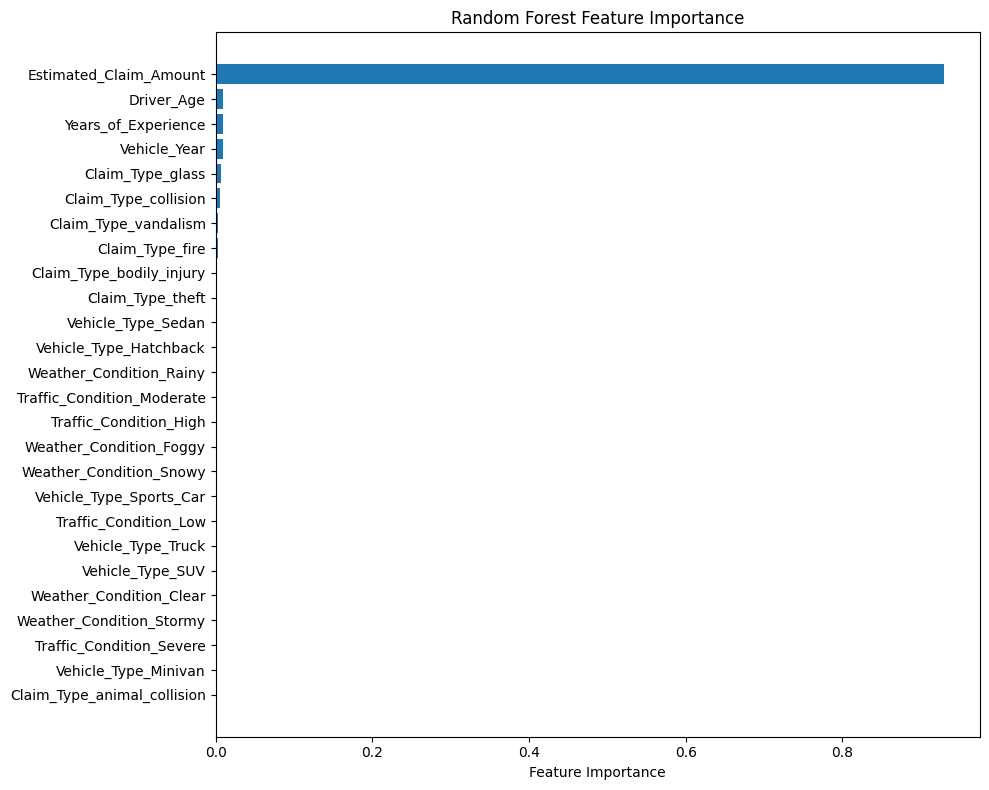

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Replace these
model = Random_forest_model
features_names = x_train.columns

#Extracting importance
importsnces = model.feature_importances_
indices = np.argsort(importsnces)

plt.figure(figsize=(10,8))
plt.barh(range(len(importsnces)), importsnces[indices])
plt.yticks(range(len(importsnces)), features_names[indices])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()


**Saving the best Model**

In [71]:
os.makedirs("models", exist_ok=True)

joblib.dump(Random_forest_model, "models/best_model.pkl")
joblib.dump(x_train.columns.tolist(), "models/feature_columns.pkl")

print("Model and feature columns saved")


Model and feature columns saved


In [72]:
#os.makedirs("models", exist_ok=True)
#joblib.dump(Random_forest_model, "models/best_model.pkl")
#print("Model saved locally as models/best_model.pkl")

In [73]:
#feature_columns = x_train.columns.tolist()

#with open("models/best_model.pkl", "wb") as f:
    #joblib.dump(feature_columns, f)